In [1]:
import os
import json
import pandas as pd
import numpy as np
import pprint as pp
import pickle as pkl

import torch
from sklearn.model_selection import train_test_split
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import TextClassificationPipeline, pipeline, set_seed
from datasets import load_from_disk

In [2]:
PROJECT_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
SHAP_DIR = os.path.join(PROJECT_DIR, "classification/shap_values/coqa")
SPLITS_DIR = os.path.join(PROJECT_DIR, "classification/split_datasets/coqa")
MODELS_DIR = os.path.join(PROJECT_DIR, "classification/models")
OUTPUT_DIR = os.path.join(PROJECT_DIR, 'classification/preds')
LOGS_DIR = os.path.join(PROJECT_DIR, 'logs')

path_to_existing_model = os.path.join(MODELS_DIR, "distilbert-base-uncased_13091207")

responses_file = os.path.join(PROJECT_DIR, 'responses/12091031_parsed_turbo_10000_eval.jsonl')
raw_dataset = load_from_disk(SPLITS_DIR)

balance_dataset = False
# enforce use of a single gpu (2 solutions implemented)
use_latest_solution = False # tmp solution - False to use the first one

!export "CUDA_VISIBLE_DEVICES"=2 jupyter notebook
!export "CUDA_VISIBLE_DEVICES"=2
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

### Retrieve training args of existing model (distilBERT v1)

In [3]:
class customTrainingArguments(TrainingArguments):
    def __init__(self,*args, **kwargs):
        super(customTrainingArguments, self).__init__(*args, **kwargs)

    @property
    #@torch_required
    def device(self) -> "torch.device":
        """
        The device used by this process.
        Name the device the number you use.
        """
        return torch.device("cuda:2")

    @property
    #@torch_required
    def n_gpu(self):
        """
        The number of GPUs used by this process.
        Note:
            This will only be greater than one when you have multiple GPUs available but are not using distributed
            training. For distributed training, it will always be 1.
        """
        # Make sure `self._n_gpu` is properly setup.
        # _ = self._setup_devices
        # I set to one manullay
        self._n_gpu = 1
        return self._n_gpu

In [4]:
path_to_training_args = os.path.join(path_to_existing_model, "training_args.bin")
v1_training_args = torch.load(path_to_training_args)
v1_training_args

customTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_backend=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=50,
evaluation_strategy=steps,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=False,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_

### Eval existing model (distilbert v1)

In [13]:
tokenizer = AutoTokenizer.from_pretrained(path_to_existing_model)
model = AutoModelForSequenceClassification.from_pretrained(path_to_existing_model)
model.to(device)

pipe = pipeline("text-classification",
    tokenizer=tokenizer,
    model=model,
    #top_k=None, # get confidence scores for predictions
    # `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
)
pipe.device = device

In [41]:
# make pred on validation set with pipe
val_preds = pipe(raw_dataset['validation']['text'])
test_preds = pipe(raw_dataset['test']['text'])

In [26]:
import evaluate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import pprint as pp

def get_all_evals(split_preds, split='validation'):
    task_evaluator = evaluate.evaluator("text-classification")
    evaluate_results = task_evaluator.compute(
        model_or_pipeline=pipe, # can also pass model
        data=raw_dataset[split],
        label_mapping={'LABEL_0': 0, 'LABEL_1': 1},
        metric=evaluate.combine(["accuracy", "recall", "precision", "f1"])
    )
    pp.pprint(evaluate_results)
    print('\n')

    y_preds = []
    y_trues = []
    for i in range(len(split_preds)):
        y_preds.append(int(split_preds[i]['label'].split('_')[1]))
        y_trues.append(0 if raw_dataset[split][i]['label']==False else 1)
    
    cm = confusion_matrix(y_trues, y_preds, labels=[0,1])
    viz = ConfusionMatrixDisplay(cm, display_labels=[0,1])
    viz.plot()

    print(classification_report(y_trues, y_preds, labels=[0,1]))

/mount/studenten-temp1/users/dpgo/xai-thesis/classification/finetune-venv/lib64/python3.10/site-packages/transformers/pipelines/base.py:1080: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'accuracy': 0.811,
 'f1': 0.8594795539033457,
 'latency_in_seconds': 0.004187132241204381,
 'precision': 0.7821380243572396,
 'recall': 0.9537953795379538,
 'samples_per_second': 238.82694464705068,
 'total_time_in_seconds': 4.187132241204381}


              precision    recall  f1-score   support

           0       0.89      0.59      0.71       394
           1       0.78      0.95      0.86       606

    accuracy                           0.81      1000
   macro avg       0.84      0.77      0.79      1000
weighted avg       0.83      0.81      0.80      1000



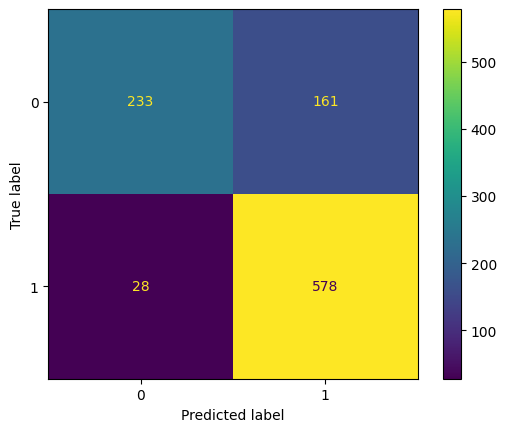

In [53]:
get_all_evals(val_preds, split='validation')

/mount/studenten-temp1/users/dpgo/xai-thesis/classification/finetune-venv/lib64/python3.10/site-packages/transformers/pipelines/base.py:1080: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'accuracy': 0.804,
 'f1': 0.8577648766328012,
 'latency_in_seconds': 0.004172272333875298,
 'precision': 0.7817460317460317,
 'recall': 0.9501607717041801,
 'samples_per_second': 239.67754738367665,
 'total_time_in_seconds': 4.1722723338752985}


              precision    recall  f1-score   support

           0       0.87      0.56      0.68       378
           1       0.78      0.95      0.86       622

    accuracy                           0.80      1000
   macro avg       0.83      0.76      0.77      1000
weighted avg       0.82      0.80      0.79      1000



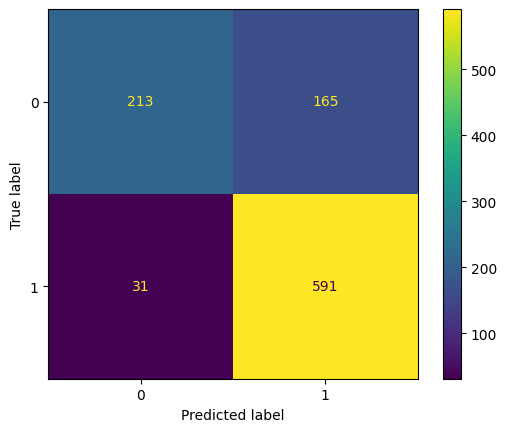

In [54]:
get_all_evals(test_preds, split='test')

## Re-train

In [5]:
set_seed(42)

label_mapping = {'False': 0, 'True': 1}

model_name = 'distilbert-base-uncased'
model_config = AutoConfig.from_pretrained(model_name,
                                          num_labels=len(label_mapping),
                                          hidden_dropout_prob=0.3,
                                          attention_probs_dropout_prob=0.3)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=model_config)

model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classi

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

### Transformers Setup

In [6]:
def tokenize_and_mask(raw_data):

    '''Tokenize
    Normal padding: set padding='max_length' and max_length=int (default is 512)
    Dynamic padding: set padding=False and (later in the Trainer) pass `data_collator=DataCollatorWithPadding(tokenizer)
    result will be a dict with keys 'input_ids', 'attention_mask'
    '''
    result = tokenizer(raw_data["text"],
                       max_length=512,
                       truncation=True,
                       #padding='max_length'
                       )

    '''Add labels'''
    if label_mapping is not None:
        if "label" in raw_data:
            result['labels'] = [label_mapping[str(label)] for label in raw_data["label"]]
    
    return result

In [7]:
'''Prepare inputs: tokenize and mask'''
dataset = raw_dataset.map(tokenize_and_mask, batched=True)

for split in ['train', 'validation', 'test']:
    dataset[split].set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [9]:
from transformers import default_data_collator, DataCollatorWithPadding

data_collator_dynamic_padding = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=8)

#### Run on single GPU 

Discussion and possible solutions here:
https://github.com/huggingface/transformers/issues/12570

with latest version (transformers-4.34.0.dev0): 
AttributeError: 'customTrainingArguments' object has no attribute 'distributed_state' (for both solutions)

downgrade to:
pip install --upgrade transformers==4.29.2

### Training Parameters

In [10]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [11]:
from transformers import Trainer, AdamW, get_cosine_schedule_with_warmup, EarlyStoppingCallback

#training_args = TrainingArguments(
training_args = customTrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=10,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    learning_rate=0.0001,
    warmup_steps=200,
    weight_decay=0.05,
    do_train=True,
    do_eval=True,
    logging_dir=LOGS_DIR,
    logging_steps=50,
    evaluation_strategy='steps',
    eval_steps=50,
    load_best_model_at_end=True, # needed for early stopping
)

optimizer = AdamW(
    model.parameters(), 
    lr=training_args.learning_rate,
    betas=(0.9, 0.98),
    eps=1e-6, # numerical stability
)

total_steps = len(dataset['train']) // training_args.per_device_train_batch_size * training_args.num_train_epochs
print(f"Number of training steps: {total_steps}")

scheduler = get_cosine_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=training_args.warmup_steps, 
    num_training_steps=total_steps,
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=v1_training_args, # defined above or v1_training_args
    train_dataset=dataset['train'],
    eval_dataset=dataset['validation'],
    data_collator=data_collator_dynamic_padding, # default_data_collator or data_collator_dynamic_padding
    optimizers=(optimizer, scheduler),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=4)],
)

Number of training steps: 2500


/mount/studenten-temp1/users/dpgo/xai-thesis/classification/finetune-venv/lib64/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Finetune + evaluate

In [12]:
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,0.674900,0.640230,0.613000,0.757974,0.610272,1.000000
100,0.583900,0.489092,0.807000,0.850272,0.802343,0.904290
150,0.496400,0.447609,0.801000,0.853999,0.768824,0.960396
200,0.494500,0.461607,0.799000,0.855500,0.757962,0.981848
250,0.497500,0.446486,0.808000,0.860668,0.768135,0.978548
300,0.483800,0.462409,0.816000,0.858243,0.804913,0.919142
350,0.480200,0.451587,0.811000,0.858002,0.787586,0.942244
400,0.481100,0.472888,0.814000,0.863034,0.779255,0.966997
450,0.435400,0.497414,0.806000,0.850998,0.795977,0.914191
500,0.470100,0.441562,0.812000,0.859281,0.786301,0.947195


TrainOutput(global_step=700, training_loss=0.4864980125427246, metrics={'train_runtime': 245.1738, 'train_samples_per_second': 326.299, 'train_steps_per_second': 10.197, 'total_flos': 1560730890964992.0, 'train_loss': 0.4864980125427246, 'epoch': 2.8})

In [13]:
len(dataset['train']) // training_args.per_device_train_batch_size # steps per epoch

250

In [44]:
def get_report(preds, split):
    y_trues = [0 if raw_dataset[split]['label'][i]==False else 1 for i in range(len(raw_dataset[split]))]
    y_preds = preds.predictions.argmax(-1)
    print(classification_report(y_trues, y_preds, labels=[0,1]))

In [45]:
split = 'validation'
get_report(trainer.predict(dataset[split]), split)

              precision    recall  f1-score   support

           0       0.88      0.60      0.72       394
           1       0.79      0.95      0.86       606

    accuracy                           0.81      1000
   macro avg       0.83      0.78      0.79      1000
weighted avg       0.82      0.81      0.80      1000



In [46]:
split = 'test'
get_report(trainer.predict(dataset[split]), split)

              precision    recall  f1-score   support

           0       0.89      0.57      0.69       378
           1       0.78      0.96      0.86       622

    accuracy                           0.81      1000
   macro avg       0.84      0.76      0.78      1000
weighted avg       0.82      0.81      0.80      1000



In [48]:
'''Save model'''
import datetime
model_id = datetime.datetime.now().strftime("%d%m%H%M")
trainer.save_model(os.path.join(MODELS_DIR, f"distilbert-base-uncased_{model_id}"))